In [51]:
from typing import TypedDict, Literal, Optional

from langgraph.graph import StateGraph, START, END

In [52]:
class HRRecruitingState(TypedDict):
    position: str
    jd: Optional[str]
    jd_approved: Optional[bool]
    jd_suggestions: Optional[str]
    job_posted: Optional[bool]
    resume_reviewed: Optional[bool]
    application_threshhold: Optional[int]
    current_number_of_application: Optional[int]
    offer_letter: Optional[str]
    offer_letter_specifications: Optional[str]
    offer_letter_approved: Optional[bool]
    offer_sent: Optional[bool]
    status: Optional[Literal[
        "received_position", "jd_created", "jd_approved", "job_posted", "resume_reviewed", "offer_sent"
    ]]

In [53]:
def get_position(state):
    print(f"--- Received position: {state['position']} ---")
    return {"status": "received_position"}

def make_jd(state):
    suggestion = state.get('jd_suggestions', '')
    state['jd'] = f"Job Description for {state['position']}. {suggestion}"
    print(f"Generated JD: {state['jd']}")
    # Reset suggestions after using them
    return {"jd": state['jd'], "jd_suggestions": None, "status": "jd_created"}

def jd_suggestions(state):
    state['jd_suggestions'] = "Include experience with Python and AI."
    print(f"JD suggestions: {state['jd_suggestions']}")
    # Return updates for state
    return {"jd_suggestions": state['jd_suggestions']}

def approve_jd(state):
    # Simulate approval logic. This node is a state updater.
    is_approved = True # Hardcoded for demonstration, would normally be user input
    print(f"JD to approve: {state['jd']}")
    
    return {"jd_approved": is_approved, "status": "jd_approved"}

def post_job(state):
    print(f"--- Posting job for: {state['position']} ---")
    print(f"Using JD: {state['jd']}")
    state['job_posted'] = True
    return {"job_posted": True, "status": "job_posted"}

def check_application_threshold_node(state):
    """
    Node function to check application counts and update state with metrics.
    Returns a dict for state update.
    """
    # Simulate application count
    threshold = 5  
    current_app_count = 6 # Set to 5 to match the original traceback (threshold met)
    print(f"Application threshold set to: {threshold}. Current count: {current_app_count}")
    
    return {
        'application_threshhold': threshold, 
        'current_number_of_application': current_app_count
    }

def tweak_job_post(state):
    state['jd'] += " (Tweaked based on feedback)"
    print(f"Tweaked JD: {state['jd']}")
    return {"jd": state['jd']}

def review_resume(state):
    state['resume_reviewed'] = True
    print("Reviewed resumes. Moving to selection.")
    return {"resume_reviewed": True, "status": "resume_reviewed"}

def schedule_interview(state):
    print("Scheduled interviews.")
    return {"interviews_scheduled": True}

def candidate_selection(state):
    print("Selected candidates for interview.")
    # Returns a dict update, the routing is handled by the conditional edge
    return {"candidate_selected": True}

def ask_for_offer_letter_specifications(state):
    state['offer_letter_specifications'] = "Standard offer letter with salary details (USD 120k)."
    print(f"Offer letter specifications: {state['offer_letter_specifications']}")
    return {"offer_letter_specifications": state['offer_letter_specifications']}

def create_offer_letter(state):
    state['offer_letter'] = f"Offer letter for position {state['position']}. Details: {state['offer_letter_specifications']}"
    print(f"Created offer letter: {state['offer_letter']}")
    return {"offer_letter": state['offer_letter']}

def approve_offer_letter(state):
    # Simulate approval logic. This node is a state updater.
    is_approved = True # Hardcoded for demonstration
    print(f"Offer letter approved: {is_approved}")
    return {"offer_letter_approved": is_approved}

def send_offer(state):
    print(f"--- Sent offer letter for {state['position']} ---")
    state['offer_sent'] = True
    return {"offer_sent": True, "status": "offer_sent"}

# 3. Router Functions (Conditional Logic)
# These functions MUST return the name of the next node (string) or END.

def route_jd_approval(state: HRRecruitingState) -> str:
    """Decides whether to post the job or ask for suggestions/rework."""
    if state.get('jd_approved'):
        return "post_job"
    else:
        # If not approved, go back to suggestions loop
        return "jd_suggestions" 

def route_on_threshold(state: HRRecruitingState) -> str:
    """Checks if the application threshold is met (based on state) and routes."""
    current_count = state.get('current_number_of_application', 0)
    threshold = state.get('application_threshhold', 0)

    if current_count >= threshold:
        print("--- Router: Threshold MET. Reviewing. ---")
        return "review_resume"
    else:
        print("--- Router: Threshold NOT MET. Tweaking. ---")
        return "tweak_job_post"

def route_candidate_selection(state: HRRecruitingState) -> str:
    """Decides if a candidate was selected or if the process ends."""
    # Since candidate_selection node returns {"candidate_selected": True}
    selection_successful = state.get("candidate_selected", False)
    
    if selection_successful:
        return "ask_for_offer_letter_specifications"
    else:
        return END

def route_offer_approval(state: HRRecruitingState) -> str:
    """Decides whether to send the offer or rework the offer letter."""
    if state.get('offer_letter_approved'):
        return "send_offer"
    else:
        # If not approved, go back to get new specifications
        return "ask_for_offer_letter_specifications"


In [58]:
graphBuilder = StateGraph(HRRecruitingState)

# Add Nodes
graphBuilder.add_node("get_position", get_position)
graphBuilder.add_node("make_jd", make_jd)
graphBuilder.add_node("approve_jd", approve_jd)
graphBuilder.add_node("jd_suggestions", jd_suggestions)
graphBuilder.add_node("post_job", post_job)
graphBuilder.add_node("tweak_job_post", tweak_job_post)
graphBuilder.add_node("review_resume", review_resume)
graphBuilder.add_node("schedule_interview", schedule_interview)
graphBuilder.add_node("candidate_selection", candidate_selection)
graphBuilder.add_node("ask_for_offer_letter_specifications", ask_for_offer_letter_specifications)
graphBuilder.add_node("create_offer_letter", create_offer_letter)
graphBuilder.add_node("approve_offer_letter", approve_offer_letter)
graphBuilder.add_node("send_offer", send_offer)
# NEW: check_application_threshold now uses the state-updating node function
graphBuilder.add_node("check_application_threshold", check_application_threshold_node) 


# Define Edges
graphBuilder.add_edge(START, "get_position")
graphBuilder.add_edge("get_position", "make_jd")
graphBuilder.add_edge("make_jd", "approve_jd")

# JD Approval Loop
graphBuilder.add_conditional_edges(
    "approve_jd",
    route_jd_approval, # Use the dedicated router
    {
        "post_job": "post_job",
        "jd_suggestions": "jd_suggestions"
    }
)
graphBuilder.add_edge("jd_suggestions", "make_jd")

# Application Threshold Loop
graphBuilder.add_conditional_edges(
    "check_application_threshold",
    route_on_threshold, # Use the pure router
    {
        "review_resume": "review_resume",
        "tweak_job_post": "tweak_job_post"  
    }
)
graphBuilder.add_edge("tweak_job_post", "post_job") 

# Hiring Phase
graphBuilder.add_edge("post_job", "check_application_threshold")
graphBuilder.add_edge("review_resume", "schedule_interview")
graphBuilder.add_edge("schedule_interview", "candidate_selection")

# Candidate Selection Edge
graphBuilder.add_conditional_edges(
    "candidate_selection",
    route_candidate_selection, # Use the dedicated router
    {
        "ask_for_offer_letter_specifications": "ask_for_offer_letter_specifications",
        END: END,
    }
)

# Offer Letter Phase
graphBuilder.add_edge("ask_for_offer_letter_specifications", "create_offer_letter")
graphBuilder.add_edge("create_offer_letter", "approve_offer_letter")

# Offer Letter Approval Loop
graphBuilder.add_conditional_edges( 
    "approve_offer_letter",
    route_offer_approval, # Use the dedicated router
    {
        "send_offer": "send_offer",
        "ask_for_offer_letter_specifications": "ask_for_offer_letter_specifications",
    }
)

# Final Edge
graphBuilder.add_edge("send_offer", END)

graph = graphBuilder.compile()


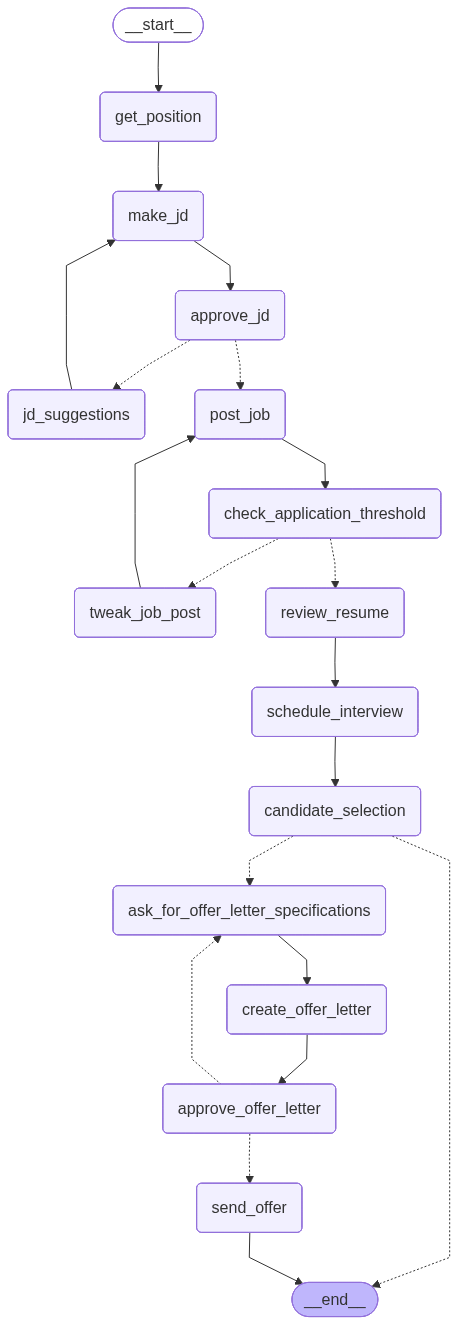

In [59]:
from IPython.display import Image, display

display(Image(graph.get_graph().draw_mermaid_png()))

In [60]:
state = graph.invoke({"position": "Software Engineer"})
print(state)


--- Received position: Software Engineer ---
Generated JD: Job Description for Software Engineer. 
JD to approve: Job Description for Software Engineer. 
--- Posting job for: Software Engineer ---
Using JD: Job Description for Software Engineer. 
Application threshold set to: 5. Current count: 6
--- Router: Threshold MET. Reviewing. ---
Reviewed resumes. Moving to selection.
Scheduled interviews.
Selected candidates for interview.
{'position': 'Software Engineer', 'jd': 'Job Description for Software Engineer. ', 'jd_approved': True, 'jd_suggestions': None, 'job_posted': True, 'resume_reviewed': True, 'application_threshhold': 5, 'current_number_of_application': 6, 'status': 'resume_reviewed'}
